In [1]:
from utils import normalize_df, create_train_test_val_df
import os
notebook_dir = os.getcwd()
root_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
data_dir = os.path.join(root_dir, 'data')
import numpy as np
import pandas as pd
from sklearn.metrics import brier_score_loss, make_scorer, log_loss, mean_squared_error
from IPython.display import display_html
from copy import deepcopy
import pickle
from sklearn import calibration
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GroupKFold, RandomizedSearchCV, cross_val_predict, GridSearchCV
from sklearn.linear_model import LogisticRegression
# from utils.utils
pd.set_option("display.max_columns", None)


In [2]:
def normalize_df(df, anchor_df=None):
    for col in df.columns:
        data = df[col]
        if anchor_df is None:
            df[col] = (data - np.min(data)) / (np.max(data) - np.min(data))
        else:
            df[col] = (data - np.min(anchor_df[col])) / (np.max(anchor_df[col]) - np.min(anchor_df[col]))
    return df

def create_train_test_val_df(
    df,
    input_names,
    output_name,
    group_col="game_code",
    mask_test_season=2021,
    mask_val_season=2020,
    normalize=False
):
    mask_train = ~(df.season.isin([mask_test_season, mask_val_season]))
    mask_test = (df.season == mask_test_season)
    mask_val = (df.season == mask_val_season)
    if normalize==False:
        X_train = df.loc[mask_train, input_names]
        X_test = df.loc[mask_test, input_names]
        X_val = df.loc[mask_val, input_names]
    else:
        X_train = normalize_df(df.loc[mask_train, input_names])
        X_test = normalize_df(df.loc[mask_test, input_names], df.loc[mask_train, input_names])
        X_val = normalize_df(df.loc[mask_val, input_names], df.loc[mask_train, input_names])
    y_train = df[mask_train][output_name]
    group_train = df[mask_train][group_col]
    y_test = df[mask_test][output_name]
    group_test = df[mask_test][group_col]
    y_val = df[mask_val][output_name]
    group_val = df[mask_val][group_col]
    return X_train, y_train, group_train, X_test, y_test, group_test, X_val, y_val, group_val

In [3]:
event_df = pd.read_parquet(os.path.join(data_dir, "event_data.parquet"))
event_df = event_df.drop_duplicates(["nevent", "game_code"]).reset_index(drop=True)
odds_df = pd.read_parquet(os.path.join(data_dir, "odds_data.parquet"))
odds_df = odds_df.drop_duplicates("game_code")
event_ids = event_df[["event_id", "event_name"]].drop_duplicates().sort_values("event_id").reset_index(drop=True)
event_ids.to_csv(os.path.join(data_dir, "event_ids.csv"))


event_df["half"] = round((event_df["quarter"] + 0.01) / 2)
event_df["home_timeout"] = np.where(((event_df["event_id"]==57)&(event_df["home_team_has_ball"]==1))|((event_df["event_id"]==58)&(event_df["home_team_has_ball"]==0)), 1, 0)
event_df["away_timeout"] = np.where(((event_df["event_id"]==57)&(event_df["home_team_has_ball"]==0))|((event_df["event_id"]==58)&(event_df["home_team_has_ball"]==1)), 1, 0)
event_df["home_timeouts_remaining"] = np.clip(3 - event_df.groupby(["game_code", "half"])["home_timeout"].cumsum(), 0, 3)
event_df["away_timeouts_remaining"] = np.clip(3 - event_df.groupby(["game_code", "half"])["away_timeout"].cumsum(), 0, 3)
event_df["time_left_in_game"] = np.where(event_df["quarter"] <= 4, event_df["play_start_time"] + (4 - event_df["quarter"]) * 900, event_df["play_start_time"])
event_df["time_elapsed"] = 900 - event_df["play_start_time"] + (event_df["quarter"] - 1) * 900


event_df[["cur_spread", "cur_over_under"]] = event_df.merge(odds_df, how="left", on="game_code")[["cur_spread", "cur_over_under"]].fillna({"cur_spread": np.mean(odds_df["cur_spread"]), "cur_over_under": np.mean(odds_df["cur_over_under"])})
event_df["sequence"] = event_df["continuation"].groupby(event_df["continuation"].eq(0).cumsum()).cumsum()
event_df["play_start_id"] = event_df["nevent"] - event_df["sequence"]

turnover_ids = [9, 16]
# mask_turnover_on_downs = (event_df["down"]==4)&(event_df["field_goal_attempt"]==0)&(event_df["punt"]==0)&(event_df["yards_gained"]<event_df["ytg"])&(event_df["home_team_has_ball"]!=event_df.shift(-1)["home_team_has_ball"])
event_df["turnover"] = np.where(event_df["event_id"].isin(turnover_ids), 1, 0)
event_df["touchdown_scored"] = np.where(event_df["home_score_added"]+event_df["away_score_added"]>=6, 1, 0)
event_df["fieldgoal_made"] = np.where(event_df["home_score_added"]+event_df["away_score_added"]==3, 1, 0)

play_outcome_aggregate =event_df[["game_code", "play_start_id", "turnover", "touchdown_scored", "fieldgoal_made", "first_down"]].groupby(["game_code", "play_start_id"], as_index=False).sum()
# touchdown_key_df =event_df[["game_code", "play_start_id", "turnover"]].groupby(["game_code", "play_start_id"], as_index=False).sum()
event_df["touchdown_in_play"] = np.clip(event_df.merge(play_outcome_aggregate,on=["game_code", "play_start_id"], how="left")["touchdown_scored_y"], 0, 1)
event_df["turnover_in_play"] = np.clip(event_df.merge(play_outcome_aggregate,on=["game_code", "play_start_id"], how="left")["turnover_y"], 0, 1)
event_df["field_goal_in_play"] = np.clip(event_df.merge(play_outcome_aggregate,on=["game_code", "play_start_id"], how="left")["fieldgoal_made_y"], 0, 1)
event_df["first_down_in_play"] = np.clip(event_df.merge(play_outcome_aggregate,on=["game_code", "play_start_id"], how="left")["first_down_y"], 0, 1)


# drive_outcome_aggregate =event_df[["game_code", "off_team_id", "drive_id", "turnover", "touchdown_scored", "fieldgoal_made"]].groupby(["game_code", "off_team_id", "drive_id"], as_index=False).sum()
# event_df["touchdown_in_drive"] = np.clip(event_df.merge(drive_outcome_aggregate,on=["game_code", "drive_id", "off_team_id"], how="left")["touchdown_scored_y"], 0, 1)
# event_df["turnover_in_drive"] = np.clip(event_df.merge(drive_outcome_aggregate,on=["game_code", "drive_id", "off_team_id"], how="left")["turnover_y"], 0, 1)
# event_df["field_goal_in_drive"] = np.clip(event_df.merge(drive_outcome_aggregate,on=["game_code", "drive_id", "off_team_id"], how="left")["fieldgoal_made_y"], 0, 1)

event_df["play_outcome"] = (
    np.where((event_df["turnover_in_play"]==1), "turnover",
    # (event_df["touchdown_in_play"]==1)&(event_df["turnover_in_play"]==1), "defensive_touchdown", 
    np.where((event_df["punt"]==1), "punt",
    np.where((event_df["field_goal_in_play"]==1), "field_goal_made",
    np.where((event_df["field_goal_attempt"]==1)&(event_df["field_goal_in_play"]==0), "field_goal_missed",
    np.where((event_df["first_down_in_play"]==1)&(event_df["touchdown_in_play"]==0)&(event_df["turnover_in_play"]==0)&(event_df["punt"]==0), "first_down",
    np.where((event_df["touchdown_in_play"]==1)&(event_df["turnover_in_play"]==0), "offensive_touchdown", "none"))))))
)
drive_description_matrix = {
    7: "punt",
    9: "turnover",
    14: "turnover",
    17: "field_goal_made",
    18: "punt",
    20: "safety",
    35: "field_goal_missed",
    36: "field_goal_missed",
    37: "touch_down",
    38: "clock",
    39: "clock",
    40: "turnover_on_downs",
    42: "field_goal_made",
    51: "clock",
}
event_df["drive_outcome_desc_basic"] = event_df["drive_outcome_id"].map(drive_description_matrix)

# event_df["drive_outcome"] = np.where(
#     (event_df["touchdown_in_drive"]==1)&(event_df["turnover_in_drive"]==1), "defensive_touchdown", 
#     np.where((event_df["touchdown_in_drive"]==1)&(event_df["turnover_in_drive"]==0), "offensive_touchdown",
#     np.where((event_df["field_goal_in_drive"]==1), "field_goal_made",
#     np.where((event_df["touchdown_in_drive"]==0)&(event_df["turnover_in_drive"]==1), "turnover", "none"
# ))))
scrimmage_plays_we_want = [1, 2, 3, 4, 7, 9, 14, 17, 18, 35]
game_end_of_regulation_total_score = event_df[event_df.overtime==0].groupby("game_code", as_index=False).max()[["game_code", "home_start_score", "away_start_score"]]
game_end_of_regulation_total_score["end_of_regulation_score_total"] = game_end_of_regulation_total_score["home_start_score"] + game_end_of_regulation_total_score["away_start_score"]
# event_df["end_of_regulation_score_total_diff"] = 
event_df["end_of_regulation_score_total_diff"] = (
    event_df.merge(game_end_of_regulation_total_score, on="game_code")["end_of_regulation_score_total"]
    - (event_df["home_start_score"] + event_df["away_start_score"])
)

/var/folders/dq/tcxv3s4j7y585_4jhfbdvrx00000gn/T/ipykernel_12333/1780316817.py:75: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  game_end_of_regulation_total_score = event_df[event_df.overtime==0].groupby("game_code", as_index=False).max()[["game_code", "home_start_score", "away_start_score"]]


In [4]:
# model_df["game_type_desc"].value_counts()

def flip_and_reverse_it(df, negative_cols=[]):
    reverse_df = deepcopy(df)
    for col in negative_cols:
        reverse_df[col] = -df[col]
    
    home_team_cols = [col for col in df.columns if 'home' in col]
    away_team_cols = [col for col in df.columns if 'away' in col]
    # print(team_cols)
    for col in home_team_cols:
        df[col.replace("home", "team")] = df.loc[:, col]
        df[col.replace("home", "opp")] = df.loc[:, col.replace("home", "away")]
        reverse_df[col.replace("home", "team")] = df.loc[:, col.replace("home", "away")]
        reverse_df[col.replace("home", "opp")] = df.loc[:, col]
        print(home_team_cols + away_team_cols)
    # for col in away_team_cols:
    #     reverse_df[col.replace("away", "team")] = df.loc[col]
    #     df[col.replace("away", "team")] = df.loc[col.replace("away", "home")]
    df = df.drop(home_team_cols + away_team_cols, axis=1)
    reverse_df = reverse_df.drop(home_team_cols + away_team_cols, axis=1)
    return pd.concat([df, reverse_df])
    # for col in one_minus_cols:
    #     reverse_df[col] = 1 - 


In [5]:
# overtime_games = event_df[event_df.overtime==1]

output_name = "play_outcome"

model_df = deepcopy(event_df)
model_df["time_left_in_half"] = event_df["time_left_in_game"] - ((2 - event_df["half"]) * 1800)
model_df["from_scrimmage"] = np.where(event_df["event_id"].isin([22, 52, 53, 55, 47, 54, 56]), 0, event_df["from_scrimmage"])
model_df["ytg"] = np.where(model_df["from_scrimmage"] == 0, -1, event_df["ytg"])
model_df["down"] = np.where(model_df["from_scrimmage"] == 0, 0, event_df["down"])
model_df["home_team_has_ball"] = np.where(event_df["event_id"].isin([5]), 1 - event_df["home_team_has_ball"], event_df["home_team_has_ball"])
model_df["yd_from_goal"] = np.where(model_df["from_scrimmage"] == 0, -1, event_df["yd_from_goal"])
model_df["point_after_play"] = np.where(model_df["point_after_kick"] + model_df["two_point_attempt"]==1, 1, 0)


model_df["away_vegas_score_pred"] = np.clip(model_df["cur_over_under"], 30, 80) * 0.5 + model_df["cur_spread"] * 0.5
model_df["home_vegas_score_pred"] = np.clip(model_df["cur_over_under"], 30, 80) * 0.5 - model_df["cur_spread"] * 0.5
model_df["away_vegas_score_pred_weighted"] = model_df["away_vegas_score_pred"] * (model_df["time_left_in_game"] / 3600)
model_df["home_vegas_score_pred_weighted"] = model_df["home_vegas_score_pred"] * (model_df["time_left_in_game"] / 3600)
model_df["cur_over_under"] = np.clip(event_df["cur_over_under"], 30, 80)
model_df["is_playoff_game"] = np.where(model_df["game_type_id"] == 1, 0, 1)
team_specific_cols = []
for col in ["ytg", "yd_from_goal", "down", "kick_off"]:
    model_df["home_" + col] = model_df[col].where(model_df["home_team_has_ball"]==1, 0)
    model_df["away_" + col] = model_df[col].where(model_df["home_team_has_ball"]==0, 0)
    team_specific_cols = team_specific_cols + ["home_" + col] + ["away_" + col]
model_df["away_team_has_ball"] = 1 - model_df["home_team_has_ball"]
model_df["is_home"] = 1
model_df["is_away"] = 0


search_rf_play_outcome = pickle.load(open(os.path.join(root_dir, "models/search_rf_play_outcome.p"), 'rb'))
# search_mlp_play_outcome = pickle.load(open(os.path.join(root_dir, "models/search_mlp_play_outcome.p"), 'rb'))
search_rf_drive_outcome = pickle.load(open(os.path.join(root_dir, "models/search_rf_drive_outcome.p"), 'rb'))
# search_mlp_drive_outcome = pickle.load(open(os.path.join(root_dir, "models/search_mlp_drive_outcome.p"), 'rb'))




/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.1.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.1.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.

In [6]:
model_df[["is_playoff_game", "game_type_desc", "game_type_id"]].value_counts()

is_playoff_game  game_type_desc      game_type_id
0                Regular Season      1               782821
1                Wild Card Playoff   6                12852
                 Divisional Playoff  2                12076
                 Conf. Championship  7                 6039
                 Super Bowl          3                 3010
dtype: int64

In [7]:
input_names_score_pred = [
    'time_left_in_half',
    # 'half',
    'current_score_diff',
    'current_score_total',
    # 'home_vegas_score_pred_weighted',
    # 'away_vegas_score_pred_weighted',
    'cur_spread',
    'cur_over_under',
    'home_timeouts_remaining',
    'away_timeouts_remaining',
    'home_ytg',
    'away_ytg',
    'home_yd_from_goal',
    'away_yd_from_goal',
    'home_down',
    'away_down',
    'home_team_has_ball',
    'away_team_has_ball',
    'is_home',
    'is_away',
    'home_kick_off',
    'away_kick_off',
    'is_playoff_game',
    # 'point_after_kick',
    # 'two_point_attempt',
    # 'point_after_play',
]
output_name = "final_score_diff"

mask_model = (
    (model_df.continuation==0)&
    (model_df[input_names_score_pred+[output_name]].notna().all(axis=1))&
    ~(model_df.event_id.isin([57,58,13]))&
    (model_df["overtime"]==1)&
    (model_df["final_score_diff"]!=2)
)
search_rf_play_outcome_classes = ["search_rf_play_" + x for x in search_rf_play_outcome.classes_]
search_rf_drive_outcome_classes = ["search_rf_drive_" + x for x in search_rf_drive_outcome.classes_]
search_rf_drive_outcome_classes_home = ["home_" + x for x in search_rf_drive_outcome_classes]
search_rf_drive_outcome_classes_away = ["away_" + x for x in search_rf_drive_outcome_classes]
model_df[search_rf_drive_outcome_classes] = pd.DataFrame(search_rf_drive_outcome.predict_proba(model_df[mask_model][search_rf_drive_outcome.feature_names_in_]), index=model_df[mask_model].index)
model_df[search_rf_drive_outcome_classes_home] = model_df[search_rf_drive_outcome_classes].where((model_df["home_team_has_ball"]==1)&(model_df["down"]!=0), 0)
model_df[search_rf_drive_outcome_classes_away] = model_df[search_rf_drive_outcome_classes].where((model_df["home_team_has_ball"]==0)&(model_df["down"]!=0), 0)
extra_cols = ["season", "game_code", output_name, "drive_id", "play_start_time", "nevent", "event_name", "event_id",]

overtime_df = flip_and_reverse_it(model_df[mask_model][input_names_score_pred +search_rf_drive_outcome_classes_home +search_rf_drive_outcome_classes_away + extra_cols], negative_cols=["cur_spread", "current_score_diff", output_name])


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  11 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  13 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  15 tasks      | elapsed:    0.1s
[Para

In [8]:
overtime_first_play = overtime_df[["team_team_has_ball", "drive_id", "is_team", "game_code"]].dropna().drop_duplicates(["game_code", "is_team"])
overtime_df["first_team_team_has_ball"] = overtime_df.merge(overtime_first_play, on=["game_code", "is_team"], how="left")["team_team_has_ball_y"].values
overtime_df["first_drive_id"] = overtime_df.merge(overtime_first_play, on=["game_code", "is_team"], how="left")["drive_id_y"].values
overtime_df["start_of_overtime"] = np.where(overtime_df["season"]>=2017, 600, 900)
overtime_df["first_drive"] = ((overtime_df["first_team_team_has_ball"] == overtime_df["team_team_has_ball"] )&(overtime_df["first_drive_id"] == overtime_df["drive_id"]))|(overtime_df["start_of_overtime"]==overtime_df["play_start_time"])
overtime_df["field_goal_ends_game"] = np.where(((overtime_df["season"]>=2012)|((overtime_df["season"]>=2010)&(overtime_df["is_playoff_game"]==1)))&((overtime_df["first_drive"])|(~(overtime_df["first_drive"])&(overtime_df["current_score_diff"]!=0))), 0, 1)
overtime_df["field_goal_ends_game_team"] = overtime_df['field_goal_ends_game'].where(overtime_df.team_team_has_ball==1, 0)
overtime_df["field_goal_ends_game_opp"] = overtime_df['field_goal_ends_game'].where(overtime_df.opp_team_has_ball==1, 0)
# overtime_df

In [10]:
os.system('say "done"')


0

In [12]:
# overtime_df[search_rf_drive_outcome_classes] = pd.DataFrame(search_rf_drive_outcome.predict_proba(model_df[mask_model][search_rf_drive_outcome.feature_names_in_]), index=model_df[mask_model].index)
# overtime_df[search_rf_drive_outcome_classes] = pd.DataFrame(search_rf_drive_outcome.predict_proba(model_df[mask_model][search_rf_drive_outcome.feature_names_in_]), index=model_df[mask_model].index)
input_names_score_pred_new = [
    'time_left_in_half',
    'current_score_diff',
    'current_score_total',
    'cur_spread',
    'cur_over_under',
    'team_timeouts_remaining',
    'opp_timeouts_remaining',
    'team_ytg',
    'opp_ytg',
    'team_yd_from_goal',
    'opp_yd_from_goal',
    'team_down',
    'opp_down',
    'team_team_has_ball',
    'opp_team_has_ball',
    'is_team',
    'is_opp',
    'team_kick_off',
    'opp_kick_off',
    'team_search_rf_drive_clock',
    'opp_search_rf_drive_clock',
    'team_search_rf_drive_field_goal_made',
    'opp_search_rf_drive_field_goal_made',
    'team_search_rf_drive_field_goal_missed',
    'opp_search_rf_drive_field_goal_missed',
    'team_search_rf_drive_punt',
    'opp_search_rf_drive_punt',
    # 'team_search_rf_drive_safety',
    # 'opp_search_rf_drive_safety',
    'team_search_rf_drive_touch_down',
    'opp_search_rf_drive_touch_down',
    'team_search_rf_drive_turnover',
    'opp_search_rf_drive_turnover',
    'team_search_rf_drive_turnover_on_downs',
    'opp_search_rf_drive_turnover_on_downs',
    'field_goal_ends_game_team',
    'field_goal_ends_game_opp',
]
X_train, y_train, group_train, X_test, y_test, group_test, X_val, y_val, group_val = create_train_test_val_df(overtime_df, input_names_score_pred_new, output_name, normalize=True)
log_loss_scorer = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

cv=GroupKFold(n_splits=3)

mlp_overtime_base_model = MLPClassifier(verbose=False, early_stopping=True, n_iter_no_change=5, random_state=1)
mlp_grid = {
    'hidden_layer_sizes': [(20), (50,50,50), (10,30,10),(100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

mlp_overtime_model = GridSearchCV(mlp_overtime_base_model, mlp_grid, cv=cv,n_jobs=-1,verbose=100, scoring=log_loss_scorer)
mlp_overtime_model.fit(X_train.values, y_train.values, groups=group_train.values)
pickle.dump(mlp_overtime_model, open(os.path.join(root_dir, 'models/mlp_overtime_model.p'), 'wb'))

logit_overtime_model = LogisticRegression(solver='liblinear', random_state=0)
logit_overtime_model.fit(X_train, y_train)
pickle.dump(logit_overtime_model, open(os.path.join(root_dir, 'models/logit_overtime_model.p'), 'wb'))
rf_grid = {
    "n_estimators": np.linspace(start=10, stop=100, num=5, dtype=int),
    # "max_features": ["auto", "sqrt"],
    "max_depth": np.linspace(5, 15, num=4, dtype=int),
    "min_samples_split": [2],
    "min_samples_leaf": [1],
    "bootstrap": [True, False],
}


rf_overtime_base_model = RandomForestClassifier(verbose=0, n_jobs=1, random_state=1)
X_train, y_train, group_train, X_test, y_test, group_test, X_val, y_val, group_val = create_train_test_val_df(overtime_df, input_names_score_pred_new, output_name, normalize=False)
rf_overtime_model = GridSearchCV(rf_overtime_base_model, rf_grid, cv=cv,n_jobs=-1,verbose=100, scoring=log_loss_scorer)
rf_overtime_model.fit(X_train, y_train, groups=group_train)
pickle.dump(rf_overtime_model, open(os.path.join(root_dir, 'models/rf_overtime_model.p'), 'wb'))





# mlp_overtime_model = pickle.load(open(os.path.join(root_dir, "models/mlp_overtime_model.p"), 'rb'))
# rf_overtime_model = pickle.load(open(os.path.join(root_dir, "models/rf_overtime_model.p"), 'rb'))
# logit_play_outcome_basic = pickle.load(open(os.path.join(root_dir, "models/logit_play_outcome_basic.p"), 'rb'))
os.system('say "done"')




Fitting 3 folds for each of 32 candidates, totalling 96 fits
[CV 1/3; 2/32] START activation=tanh, alpha=0.0001, hidden_layer_sizes=20, learning_rate=adaptive, solver=adam
[CV 2/3; 2/32] START activation=tanh, alpha=0.0001, hidden_layer_sizes=20, learning_rate=adaptive, solver=adam
[CV 3/3; 2/32] START activation=tanh, alpha=0.0001, hidden_layer_sizes=20, learning_rate=adaptive, solver=adam
[CV 1/3; 1/32] START activation=tanh, alpha=0.0001, hidden_layer_sizes=20, learning_rate=constant, solver=adam
[CV 2/3; 3/32] START activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam
[CV 3/3; 1/32] START activation=tanh, alpha=0.0001, hidden_layer_sizes=20, learning_rate=constant, solver=adam
[CV 1/3; 3/32] START activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam
[CV 2/3; 1/32] START activation=tanh, alpha=0.0001, hidden_layer_sizes=20, learning_rate=constant, solver=adam
[CV 1/3; 2/32] END activation=t

0

In [13]:
pd.DataFrame(rf_overtime_model.cv_results_).to_clipboard()

In [14]:
pd.DataFrame(mlp_overtime_model.cv_results_).to_clipboard()

In [15]:
pd.concat([pd.DataFrame(logit_overtime_model.intercept_, columns=["intercept"]), pd.DataFrame(logit_overtime_model.coef_, columns=logit_overtime_model.feature_names_in_)], axis=1)

,intercept,time_left_in_half,current_score_diff,current_score_total,cur_spread,cur_over_under,team_timeouts_remaining,opp_timeouts_remaining,team_ytg,opp_ytg,team_yd_from_goal,opp_yd_from_goal,team_down,opp_down,team_team_has_ball,opp_team_has_ball,is_team,is_opp,team_kick_off,opp_kick_off,team_search_rf_drive_clock,opp_search_rf_drive_clock,team_search_rf_drive_field_goal_made,opp_search_rf_drive_field_goal_made,team_search_rf_drive_field_goal_missed,opp_search_rf_drive_field_goal_missed,team_search_rf_drive_punt,opp_search_rf_drive_punt,team_search_rf_drive_touch_down,opp_search_rf_drive_touch_down,team_search_rf_drive_turnover,opp_search_rf_drive_turnover,team_search_rf_drive_turnover_on_downs,opp_search_rf_drive_turnover_on_downs,field_goal_ends_game_team,field_goal_ends_game_opp
0,-1.599928,0.574251,-4.604631,0.217414,2.239005,-0.045987,1.496477,-0.110855,0.632336,-0.124825,0.722469,-0.378935,-0.040157,-0.019366,-1.960894,0.360966,-0.681946,-0.917983,0.415044,0.160489,1.391291,2.387939,-1.212789,-1.089992,-0.572722,0.246226,0.518720,-0.600894,-1.734575,2.604253,0.043605,-0.013900,0.201543,0.523933,0.432624,-1.545961
1,-0.640509,0.303928,-0.905019,-0.004609,0.441959,0.174105,0.143274,0.004522,-0.730742,0.242778,1.699630,-1.769534,0.146187,0.077629,-0.324661,-0.315848,-0.457254,-0.183255,0.630915,-0.242605,-1.809430,-1.750914,-0.957835,2.112289,1.114452,-0.537049,0.225109,0.312926,-1.323024,-0.042089,-0.064696,1.163084,-0.219053,0.425613,-0.170404,1.037814
2,0.680173,-2.607686,0.088353,-0.257607,0.022657,-0.335643,-0.803056,-0.798406,-0.083718,-0.087698,0.196391,0.193059,-0.796634,-0.797494,0.342940,0.337233,0.340476,0.339696,0.099536,0.091902,0.488442,0.489521,-0.371608,-0.377613,-0.014286,-0.012795,0.276562,0.275709,-1.104712,-1.109179,0.452445,0.451734,0.174926,0.167542,-0.644287,-0.631349
3,-0.824366,0.303379,0.772468,-0.006022,-0.462034,0.173145,0.005178,0.140049,0.239712,-0.732404,-1.772703,1.698869,0.075665,0.143765,-0.409085,-0.415281,-0.275653,-0.548712,-0.260106,0.620298,-1.758830,-1.807960,2.095341,-0.962750,-0.537633,1.109946,0.301711,0.217416,-0.053368,-1.331694,1.160453,-0.068227,0.416993,-0.217361,1.041792,-0.176316
4,-2.431514,0.581393,3.816122,0.189708,-2.390601,-0.040148,-0.121249,1.448626,-0.156864,0.599223,-0.414328,0.677403,-0.053587,-0.087581,-0.081379,-2.350135,-1.340322,-1.091192,0.006885,0.274760,2.328353,1.365473,-1.196341,-1.282540,0.232291,-0.601402,-0.668887,0.464104,2.494208,-1.804137,-0.049423,-0.002765,0.468390,0.180399,-1.542325,0.375450


In [17]:
pd.DataFrame(rf_overtime_model.best_estimator_.feature_importances_, index=rf_overtime_model.feature_names_in_)

,0
time_left_in_half,0.069227
current_score_diff,0.014976
current_score_total,0.054937
cur_spread,0.041286
cur_over_under,0.037838
team_timeouts_remaining,0.029981
opp_timeouts_remaining,0.021305
team_ytg,0.003384
opp_ytg,0.006069
team_yd_from_goal,0.026026


In [19]:
overtime_df[mask_model][rf_overtime_model.feature_names_in_].reset_index(drop=True)

/var/folders/dq/tcxv3s4j7y585_4jhfbdvrx00000gn/T/ipykernel_12333/1027611426.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  overtime_df[mask_model][rf_overtime_model.feature_names_in_].reset_index(drop=True)


,time_left_in_half,current_score_diff,current_score_total,cur_spread,cur_over_under,team_timeouts_remaining,opp_timeouts_remaining,team_ytg,opp_ytg,team_yd_from_goal,opp_yd_from_goal,team_down,opp_down,team_team_has_ball,opp_team_has_ball,is_team,is_opp,team_kick_off,opp_kick_off,team_search_rf_drive_clock,opp_search_rf_drive_clock,team_search_rf_drive_field_goal_made,opp_search_rf_drive_field_goal_made,team_search_rf_drive_field_goal_missed,opp_search_rf_drive_field_goal_missed,team_search_rf_drive_punt,opp_search_rf_drive_punt,team_search_rf_drive_touch_down,opp_search_rf_drive_touch_down,team_search_rf_drive_turnover,opp_search_rf_drive_turnover,team_search_rf_drive_turnover_on_downs,opp_search_rf_drive_turnover_on_downs,field_goal_ends_game_team,field_goal_ends_game_opp
0,2700.0,0,60,-6.5,38.0,3,3,0,-1,0,-1,0,0,0,1,1,0,0,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,1
1,2700.0,0,60,-6.5,38.0,3,3,0,10,0,80,0,1,0,1,1,0,0,0,0.000000,0.005955,0.000000,0.107141,0.000000,0.017709,0.000000,0.506681,0.000000,0.174973,0.000000,0.135674,0.000000,0.048804,0,1
2,2661.0,0,60,-6.5,38.0,3,3,0,7,0,77,0,2,0,1,1,0,0,0,0.000000,0.005584,0.000000,0.098662,0.000000,0.018102,0.000000,0.554923,0.000000,0.154996,0.000000,0.123425,0.000000,0.042205,0,1
3,2655.0,0,60,-6.5,38.0,3,2,0,7,0,77,0,3,0,1,1,0,0,0,0.000000,0.004048,0.000000,0.070719,0.000000,0.018657,0.000000,0.644344,0.000000,0.115437,0.000000,0.104331,0.000000,0.040657,0,1
4,2615.0,0,60,-6.5,38.0,3,2,0,10,0,44,0,1,0,1,1,0,0,0,0.000000,0.007674,0.000000,0.198611,0.000000,0.042451,0.000000,0.269483,0.000000,0.296706,0.000000,0.110281,0.000000,0.074682,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8431,2527.0,0,48,7.0,54.5,3,3,10,0,32,0,1,0,1,0,0,1,0,0,0.002552,0.000000,0.285393,0.000000,0.055123,0.000000,0.051453,0.000000,0.462795,0.000000,0.108635,0.000000,0.034030,0.000000,1,0
8432,2486.0,0,48,7.0,54.5,3,3,3,0,25,0,2,0,1,0,0,1,0,0,0.001873,0.000000,0.272386,0.000000,0.048059,0.000000,0.033020,0.000000,0.514318,0.000000,0.083425,0.000000,0.046919,0.000000,1,0
8433,2452.0,0,48,7.0,54.5,3,2,10,0,12,0,1,0,1,0,0,1,0,0,0.001203,0.000000,0.276698,0.000000,0.029329,0.000000,0.017321,0.000000,0.552984,0.000000,0.090366,0.000000,0.032079,0.000000,1,0
8434,2407.0,0,48,7.0,54.5,3,2,8,0,10,0,2,0,1,0,0,1,0,0,0.001424,0.000000,0.298170,0.000000,0.036944,0.000000,0.011659,0.000000,0.531346,0.000000,0.088600,0.000000,0.031839,0.000000,1,0


In [24]:
preds = cross_val_predict(rf_overtime_model.best_estimator_, overtime_df[rf_overtime_model.feature_names_in_], overtime_df[output_name], groups=overtime_df["game_code"], cv=5, verbose=10,method='predict_proba')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    7.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    9.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    9.9s finished


In [23]:
rf_overtime_model.best_estimator_

RandomForestClassifier(max_depth=5, n_estimators=55, n_jobs=1, random_state=1)

In [ ]:
preds

In [25]:
overtime_df = overtime_df.reindex()

rf_overtime_model.verbose = 0
rf_overtime_outcomes = ["rf_pred_" + str(x) for x in rf_overtime_model.classes_]
overtime_df[rf_overtime_outcomes] = pd.DataFrame(cross_val_predict(rf_overtime_model.best_estimator_, overtime_df[rf_overtime_model.feature_names_in_], overtime_df[output_name], groups=overtime_df["game_code"], cv=5, verbose=10,method='predict_proba'), index=overtime_df.index)

normalize_values = normalize_df(overtime_df[rf_overtime_model.feature_names_in_], overtime_df[(overtime_df.season<2020)][rf_overtime_model.feature_names_in_])
mlp_overtime_outcomes = ["mlp_pred_" + str(x) for x in mlp_overtime_model.classes_]
overtime_df[mlp_overtime_outcomes] = pd.DataFrame(cross_val_predict(mlp_overtime_model.best_estimator_, normalize_values[rf_overtime_model.feature_names_in_], overtime_df[output_name], groups=overtime_df["game_code"], cv=5, verbose=10,method='predict_proba'), index=overtime_df.index)
logit_overtime_outcomes = ["logit_pred_" + str(x) for x in logit_overtime_model.classes_]
overtime_df[logit_overtime_outcomes] = pd.DataFrame(cross_val_predict(logit_overtime_model, normalize_values[rf_overtime_model.feature_names_in_], overtime_df[output_name], groups=overtime_df["game_code"], cv=5, verbose=10,method='predict_proba'), index=overtime_df.index)


overtime_df[list(rf_overtime_model.feature_names_in_) + rf_overtime_outcomes + mlp_overtime_outcomes + logit_overtime_outcomes].to_clipboard()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    8.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   10.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   10.4s finished
/var/folders/dq/tcxv3s4j7y585_4jhfbdvrx00000gn/T/ipykernel_12333/2734161997.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = (data - np.min(anchor_df[col])) / (np.max(anchor_df[col]) - np.min(

In [26]:
log_loss_df = overtime_df[overtime_df.season<2020]
print(log_loss(log_loss_df[output_name], log_loss_df[rf_overtime_outcomes]))
print(log_loss(log_loss_df[output_name], log_loss_df[mlp_overtime_outcomes]))
print(log_loss(log_loss_df[output_name], log_loss_df[logit_overtime_outcomes]))


1.2399635249429866
1.263379376927012
1.2587359223730978


In [27]:
log_loss_df = overtime_df[overtime_df.season>=2020]
print(log_loss(log_loss_df[output_name], log_loss_df[rf_overtime_outcomes]))
print(log_loss(log_loss_df[output_name], log_loss_df[mlp_overtime_outcomes]))
print(log_loss(log_loss_df[output_name], log_loss_df[logit_overtime_outcomes]))


1.2417402024673598
1.2719865762658786
1.2582224361571308


rf_pred_-6


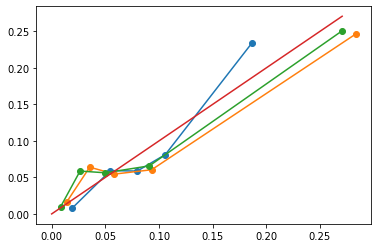

In [34]:
calb_df = overtime_df
col = 0
print(rf_overtime_outcomes[col])
calb = calibration.calibration_curve(pd.get_dummies(calb_df[output_name]).iloc[:,col], calb_df[rf_overtime_outcomes[col]], n_bins=5, strategy="quantile") 
plt.plot(calb[1], calb[0], marker="o")
calb = calibration.calibration_curve(pd.get_dummies(calb_df[output_name]).iloc[:,col], calb_df[mlp_overtime_outcomes[col]], n_bins=5, strategy="quantile") 
plt.plot(calb[1], calb[0], marker="o")
calb = calibration.calibration_curve(pd.get_dummies(calb_df[output_name]).iloc[:,col], calb_df[logit_overtime_outcomes[col]], n_bins=5, strategy="quantile") 
plt.plot(calb[1], calb[0], marker="o")
plt.plot([0, np.max(calb[1])], [0, np.max(calb[1])])



rf_pred_-3


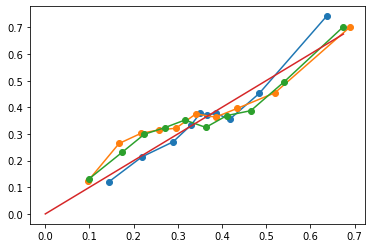

In [35]:
calb_df = overtime_df
col = 1
print(rf_overtime_outcomes[col])
calb = calibration.calibration_curve(pd.get_dummies(calb_df[output_name]).iloc[:,col], calb_df[rf_overtime_outcomes[col]], n_bins=10, strategy="quantile") 
plt.plot(calb[1], calb[0], marker="o")
calb = calibration.calibration_curve(pd.get_dummies(calb_df[output_name]).iloc[:,col], calb_df[mlp_overtime_outcomes[col]], n_bins=10, strategy="quantile") 
plt.plot(calb[1], calb[0], marker="o")
calb = calibration.calibration_curve(pd.get_dummies(calb_df[output_name]).iloc[:,col], calb_df[logit_overtime_outcomes[col]], n_bins=10, strategy="quantile") 
plt.plot(calb[1], calb[0], marker="o")
plt.plot([0, np.max(calb[1])], [0, np.max(calb[1])])



rf_pred_0


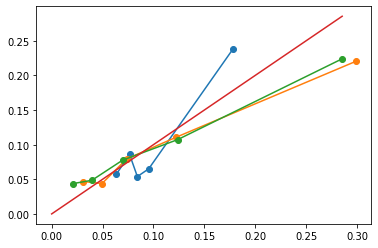

In [36]:
calb_df = overtime_df
col = 2
print(rf_overtime_outcomes[col])
calb = calibration.calibration_curve(pd.get_dummies(calb_df[output_name]).iloc[:,col], calb_df[rf_overtime_outcomes[col]], n_bins=5, strategy="quantile") 
plt.plot(calb[1], calb[0], marker="o")
calb = calibration.calibration_curve(pd.get_dummies(calb_df[output_name]).iloc[:,col], calb_df[mlp_overtime_outcomes[col]], n_bins=5, strategy="quantile") 
plt.plot(calb[1], calb[0], marker="o")
calb = calibration.calibration_curve(pd.get_dummies(calb_df[output_name]).iloc[:,col], calb_df[logit_overtime_outcomes[col]], n_bins=5, strategy="quantile") 
plt.plot(calb[1], calb[0], marker="o")
plt.plot([0, np.max(calb[1])], [0, np.max(calb[1])])



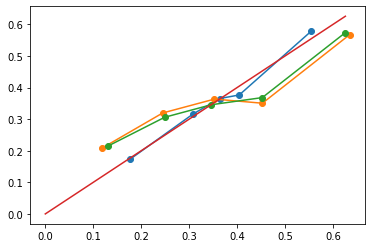

In [37]:
calb_df = overtime_df
col = 3
calb = calibration.calibration_curve(pd.get_dummies(calb_df[output_name]).iloc[:,col], calb_df[rf_overtime_outcomes[col]], n_bins=5, strategy="quantile") 
plt.plot(calb[1], calb[0], marker="o")
calb = calibration.calibration_curve(pd.get_dummies(calb_df[output_name]).iloc[:,col], calb_df[mlp_overtime_outcomes[col]], n_bins=5, strategy="quantile") 
plt.plot(calb[1], calb[0], marker="o")
calb = calibration.calibration_curve(pd.get_dummies(calb_df[output_name]).iloc[:,col], calb_df[logit_overtime_outcomes[col]], n_bins=5, strategy="quantile") 
plt.plot(calb[1], calb[0], marker="o")
plt.plot([0, np.max(calb[1])], [0, np.max(calb[1])])



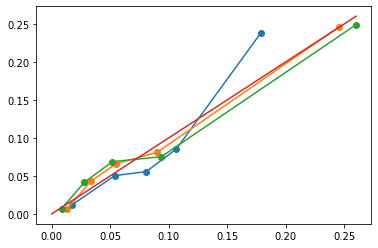

In [38]:
calb_df = overtime_df
col = 4
calb = calibration.calibration_curve(pd.get_dummies(calb_df[output_name]).iloc[:,col], calb_df[rf_overtime_outcomes[col]], n_bins=5, strategy="quantile") 
plt.plot(calb[1], calb[0], marker="o")
calb = calibration.calibration_curve(pd.get_dummies(calb_df[output_name]).iloc[:,col], calb_df[mlp_overtime_outcomes[col]], n_bins=5, strategy="quantile") 
plt.plot(calb[1], calb[0], marker="o")
calb = calibration.calibration_curve(pd.get_dummies(calb_df[output_name]).iloc[:,col], calb_df[logit_overtime_outcomes[col]], n_bins=5, strategy="quantile") 
plt.plot(calb[1], calb[0], marker="o")
plt.plot([0, np.max(calb[1])], [0, np.max(calb[1])])



In [39]:
log_loss_df = overtime_df[overtime_df.season<2020]
print(log_loss(log_loss_df[output_name], log_loss_df[rf_overtime_outcomes]))
print(log_loss(log_loss_df[output_name], log_loss_df[mlp_overtime_outcomes]))
print(log_loss(log_loss_df[output_name], log_loss_df[logit_overtime_outcomes]))


1.2399635249429866
1.263379376927012
1.2587359223730978


In [ ]:
overtime_df

In [ ]:
overtime_df

In [ ]:
plt.hist(overtime_df["rf_pred_-6"], alpha=1, bins = 5, label = "-6", range = [0, 1])
plt.hist(overtime_df["rf_pred_-3"], alpha=.75, bins = 5, label = "-3", range = [0, 1])
plt.hist(overtime_df["rf_pred_0"], alpha=.5, bins = 5, label = "0", range = [0, 1])
plt.hist(overtime_df["rf_pred_3"], alpha=.5, bins = 5, label = "3", range = [0, 1])
plt.hist(overtime_df["rf_pred_6"], alpha=.5, bins = 5, label = "6", range = [0, 1])
plt.legend()

In [ ]:
plt.hist(overtime_df["mlp_pred_-6"], alpha=1, bins = 5, label = "-6", range = [0, 1])
plt.hist(overtime_df["mlp_pred_-3"], alpha=.75, bins = 5, label = "-3", range = [0, 1])
plt.hist(overtime_df["mlp_pred_0"], alpha=.5, bins = 5, label = "0", range = [0, 1])
plt.hist(overtime_df["mlp_pred_3"], alpha=.5, bins = 5, label = "3", range = [0, 1])
plt.hist(overtime_df["mlp_pred_6"], alpha=.5, bins = 5, label = "6", range = [0, 1])
plt.legend()

In [ ]:
model_df

In [ ]:
overtime_df.to_clipboard()

In [ ]:
# plt.hist(model_df[mask_model][rf_overtime_outcomes[5]])

pd.DataFrame(rf_overtime_model.feature_importances_, rf_overtime_model.feature_names_in_)

In [ ]:
first_play_ot = model_df[mask_model].drop_duplicates("game_code")
first_play_ot[["home_team_win", "away_team_win", "home_team_has_ball"] + [output_name]].value_counts().to_clipboard()



In [ ]:
pd.DataFrame(rf_overtime_model.feature_importances_, rf_overtime_model.feature_names_in_)

In [ ]:
pd.DataFrame(mlp_overtime_model.coefs_[0], mlp_overtime_model.feature_names_in_).T.to_clipboard()
# len(mlp_overtime_model.coefs_)

In [ ]:
plt.hist(mlp_overtime_model.coefs_[0][3])